# Enron email dataset Analysis

Importing libraries

In [2]:

import nltk
import os
import random
import string
import pandas as pd
import numpy as np
import os, sys, re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer


# email module has some useful functions
import email
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

Loading dataset

In [3]:
df_emails = pd.read_csv('emails.csv')

Exploratory data analysis

In [4]:
print(df_emails.shape)
df_emails.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


Functions to pre-process the data to get email contents 

In [5]:
#extracting content
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain': 
            parts.append(part.get_payload())
    return ''.join(parts)

#splitting email addresses
def split_email_adds(line): 
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x : x.strip(), addrs))
    else:
        addrs = None
    return addrs

#function to add employee name by extracting from 'file' feature column
def add_name(df, column, labels):
    new_data = {}
    for item in df[column]: 
        tokens = item.split('/')
        for i in range(0, len(labels)):
            value = tokens[i]
            key = labels[i]
            new_data = insert_value(new_data, key, value)        
    for key, value in new_data.items():
        df[key] = pd.Series(value)
    return df

#function to insert value into dictionary
def insert_value(dictionary, key, value):
    if key in dictionary:
        values = dictionary.get(key)
        values.append(value)
        dictionary[key] = values
    else:
        dictionary[key] = [value]
    return dictionary

#Function to get Barplot
def barplot(df, X, Y, figsize, color, orient, ylabel, xlabel, font_scale, rotation):
    f, ax = plt.subplots(figsize=figsize)
    sns.set_color_codes("muted")
    sns.barplot(x = X, y = Y, data = df, color = color, orient = orient)
    ax.set(ylabel = ylabel, xlabel = xlabel)
    sns.set(font_scale = font_scale)
    plt.xticks(rotation = rotation) 
    plt.show()

Extracting required columns from the dataset

In [6]:
#Create list of email objects
msgs = list(map(email.message_from_string, df_emails['message']))
df_emails.drop('message', axis=1, inplace=True) # axis = 1 used to apply a method across each row

#Get all fields from the email objects
fields = msgs[0].keys()

for field in fields:
    df_emails[field] = [doc[field] for doc in msgs]
    
#Parse text content from emails
df_emails['Content'] = list(map(get_text_from_email, msgs))
#Split email address
df_emails['From'] = df_emails['From'].map(split_email_adds)
df_emails['To'] = df_emails['To'].map(split_email_adds)

del msgs

#Create a new column with employee name
df_emails = add_name(df = df_emails, column = "file", labels = ["Employee"])

#Limiting columns for analysis
df_Email = df_emails[['Date', 'From', 'To','Employee', 'Content', 'X-Folder']]

Parsing date into day, month and year

In [7]:
df_Email['Date'] = pd.to_datetime(df_Email['Date'], utc=True)
#print(df1_subset.iloc[:1]["Date"])

df_Email['Month'] = df_Email['Date'].apply(lambda x: x.month)
df_Email['Year'] = df_Email['Date'].apply(lambda x: x.year)
df_Email['Day'] = df_Email['Date'].apply(lambda x: x.day)

C:\Users\Prashita\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Prashita\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Prashita\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Reduce the sample period : 1997 to 2002

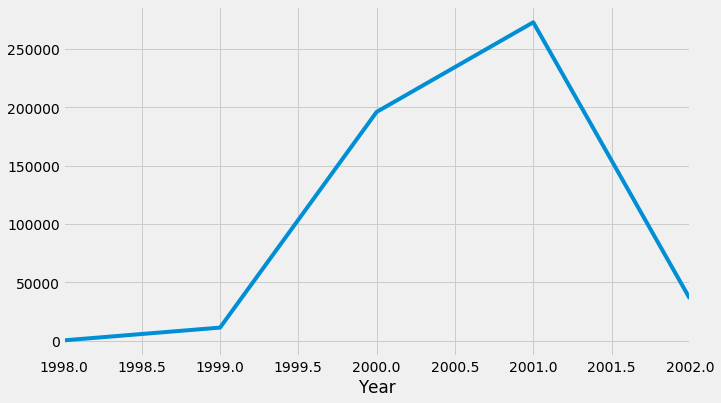

In [9]:
indices1 = (df_Email['Year'] > 1997) & (df_Email['Year'] <= 2002)
#indices2 = (df_Email['Year'] == 1999)
#indices3 = (df_Email['Year'] == 2000)
#indices4 = (df_Email['Year'] == 2001)
indices5 = (df_Email['Year'] == 2000) | (df_Email['Year'] == 2001)

#print(df_Email.columns)
plt.figure(figsize = (10,6))
figure1 = df_Email.loc[indices1].groupby('Year')['Content'].count().plot()

#df_Email2 = df_Email[indices2]
#df_Email3 = df_Email[indices3]
#df_Email4 = df_Email[indices4]
df_Email5 = df_Email[indices5]


# looks like the total number of emails shot up in years 2000 and 2001

In [10]:
cols_df_emails = df_Email.columns

Extracting names of top 20 email senders in year 2000 and 2001

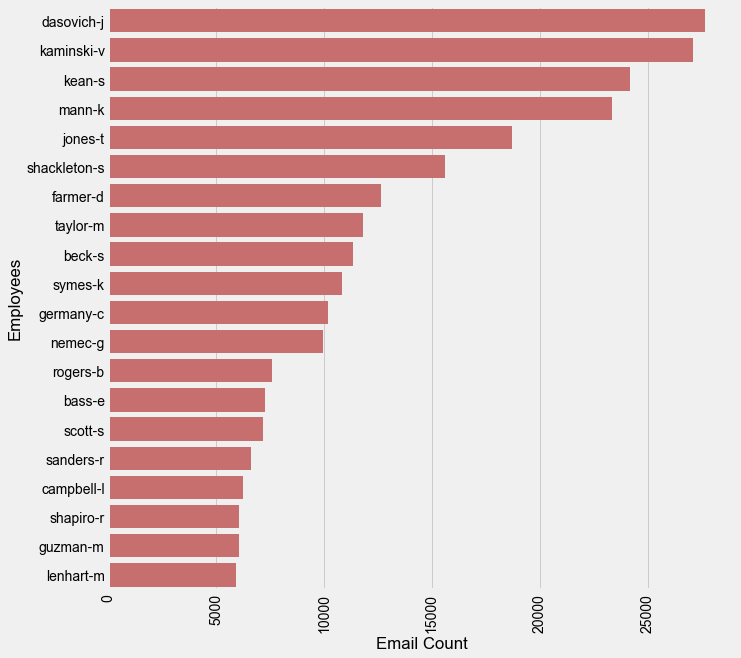

In [11]:
#getting email counts per employee
mail_count = df_Email5["Employee"].value_counts()
indices = mail_count.index
count = pd.DataFrame(mail_count)
count.rename(columns = {"Employee": "Count"}, inplace = True)
count["Employees"] = indices

barplot(df = count[:20], X = "Count", Y = "Employees", figsize = (10,10), color = 'r', orient = 'h', ylabel = "Employees", xlabel = "Email Count", font_scale = 2, rotation = 90)

### Analyzing Emails of top executives in year 2000

Names of employees being considered :

(a) Sally Beck (Chief Operating officer)

(b) Darren Farmer (Logistics Manager) 

(c) Vincent Kaminski (Head of Quantitative modeling Group)

(d) Louise Kitchen (President of EnronOnline)

(e) Michelle Lokay (Administrative assistant)

(f) Richard Sanders (Assistant General counsel)

In [13]:
#index of the above employee mails
df_EmailS5  = df_Email5.loc[(df_Email5['Employee'] == 'beck-s') | (df_Email5['Employee'] == 'farmer-d') | (df_Email5['Employee'] == 'kitchen-l') | (df_Email5['Employee'] == 'lokay-m') | (df_Email5['Employee'] == 'sanders-r') ] 

print(df_EmailS5.shape[0])

39624


In [14]:
def preprocess_folder(data):
    folders = []
    for item in data:
        if item is None or item is '':
            folders.append(np.nan)
        else:
            item = item.split("\\")[-1]
            item = item.lower()
            folders.append(item)
    return folders      
df_EmailS5["X-Folder"] = preprocess_folder(df_EmailS5["X-Folder"]) 

C:\Users\Prashita\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Randomly selecting 200 emails from this subset for training our model

In [15]:
#random.seed(40)
#index = np.random.permutation(39624)
#df_index = np.array(df_EmailS5)
#df_index = df_index[index]
#email500_idx = df_index[:500]
#sample_emails = pd.DataFrame(email500_idx, columns = cols_df_emails)
#export_csv = sample_emails.to_csv(r'C:\Users\Prashita\Desktop\New things\MS DS 19-21\Courses and materials\Fall semester 2019\ILS-Z 639 SMM\Final Project\Enron_Analysis\Sample_Emails.csv', index = None, header=True)
#print(sample_emails.shape[0])

500


Reading the randomly sampled 400 emails from the top executives

In [447]:
df_sample = pd.read_csv('Sample_Emails.csv')
df_sample400 = df_sample.head(400)

In [439]:
#read_emails = df_sample['Content']
#print(read_emails[399])

# The emails are manually labeled into 3 classes : 

(1) Class 0 : Business related emails

(2) Class 1 : In-person meetings emails

(3) Class 2 : Others that include personal, advertisement, recruitment, travel related emails, etc.

In [452]:
#Labeling the emails into Business==0 : In-person meetings==1 : other==2
mail_labels = pd.read_csv('Sample_labels.csv')
df_sample400['Labels'] = mail_labels
#print(df_sample.columns)
#print(df_sample400.head())

C:\Users\Prashita\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Using Naive bayes to train the model on the email classification problem

Here we use only the two classes 0(business related emails) and 1(in-person meetings emails) and omit the class 2(others)

Our baseline machine learning algorihthm Naive Bayes gives an average accuracy = 

## Comparing Random forest, Support vector machine, Naive Bayes and Logistic Regression classifier performance on Enron email classification

Here we carry out multi-class classification (for all three classes)

C:\Users\Prashita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Prashita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Prashita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Prashita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Prashita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarn

[('LinearSVC', 0, 0.5925925925925926), ('LinearSVC', 1, 0.6125), ('LinearSVC', 2, 0.575), ('LinearSVC', 3, 0.65), ('LinearSVC', 4, 0.7468354430379747), ('MultinomialNB', 0, 0.5185185185185185), ('MultinomialNB', 1, 0.5625), ('MultinomialNB', 2, 0.5625), ('MultinomialNB', 3, 0.6375), ('MultinomialNB', 4, 0.7088607594936709), ('LogisticRegression', 0, 0.5185185185185185), ('LogisticRegression', 1, 0.575), ('LogisticRegression', 2, 0.55), ('LogisticRegression', 3, 0.6625), ('LogisticRegression', 4, 0.6835443037974683)]
                Models  fold_idx  Accuracy
0            LinearSVC         0  0.592593
1            LinearSVC         1  0.612500
2            LinearSVC         2  0.575000
3            LinearSVC         3  0.650000
4            LinearSVC         4  0.746835
5        MultinomialNB         0  0.518519
6        MultinomialNB         1  0.562500
7        MultinomialNB         2  0.562500
8        MultinomialNB         3  0.637500
9        MultinomialNB         4  0.708861
10  L

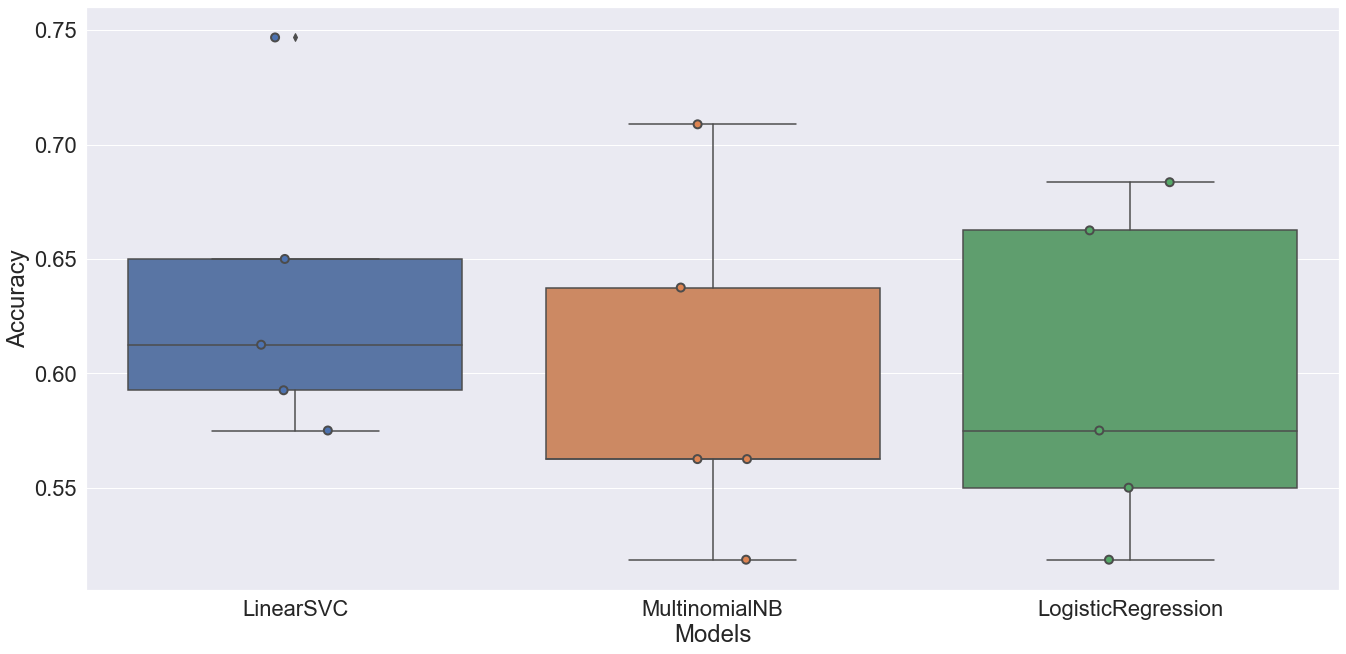

In [460]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

#extracting features using tfidf

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(df_sample400['Content']).toarray()
labels = df_sample400['Labels']

models = [ LinearSVC(), MultinomialNB(), LogisticRegression(random_state=0)]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['Models', 'fold_idx', 'Accuracy'])
print(entries)
print(cv_df)

plt.figure(figsize=(20,10))
sns.boxplot(x='Models', y='Accuracy', data=cv_df)
sns.stripplot(x='Models', y='Accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

### From the boxplot above it is clear that 
1. Linear Support Vector model performs the best with an average accuracy of 63.54%
2. Logistic and Multinomial Naive Bayes performs similarly with an accuracy of 59.79%. 
I have considered Naive Bayes as the baseline model and compared to it SVM performs better. 